# Clustering using Mean as a parameter

Clustering is the task of partitioning the dataset into groups, called clusters. The goal is to split up the data in such a way that points within a single cluster are very similar and points in different clusters are different. Similarly to classification algorithms, clustering algorithms assign (or predict) a number to each data point, indicating which cluster a particular point belongs to.

The previous talk on SVM has been concerned with predicting the values of one or more outputs or response variables $Y = (Y_1, . . . , Y_m)$ for a given set of input or predictor variables $X^{T} = (X_1, . . . , X_p)$. Denoted by $x^T_i = (x_{i1}, . . . , x_{ip})$ the inputs for the $i^{th}$ training case, and let $y_{i}$ be a response measurement. The predictions are based on the training sample $(x_1, y_1), . . . , (x_N , y_N)$ of previously solved cases, where the joint values of all of the variables are known. This is called supervised learning or learning with a teacher. Under this metaphor the student presents an answer $\hat{y}_i$ for each $x_i$ in the training sample, and the supervisor or teacher provides either the correct answer and/or an error associated with the student’s answer. This is usually characterized by some loss function $L(y, \hat{y})$. For example:

$$L(y, \hat{y}) = (y - \hat{y})^2$$

If one supposes that $(X, Y)$ are random variables represented by some joint probability density $Pr(X, Y)$, then supervised learning can be formally characterized as a density estimation problem where one is concerned with determining properties of the conditional density $Pr(Y|X)$. Usually the properties of interest are the location parameters $\mu$ that minimize the expected error at each x,

$$\mu(x) = \text{argmin}_{\theta \in \Theta} \;E_{Y|X} L(Y, \theta)$$

where, $\Theta$ is the set of all classes.


In this talk we address unsupervised learning or learning without a teacher. In this case one has a set of $N$ observations $(x_1,x_2,...,x_N)$ of a random p-vector $X$ having joint density $Pr(X)$. The goal is to directly infer the properties of this probability density without the help of a supervisor or teacher providing correct answers or degree-of-error for each observation. The dimension of $X$ is sometimes much higher than in supervised learning, and the properties of interest are often more complicated than simple location estimates. These factors are somewhat mitigated by the fact that $X$ represents all of the variables under consideration; one is not required to infer how the properties of $Pr(X)$ change, conditioned on the changing values of another set of variables. With unsupervised learning we aim to find a plausible compact description of the data. An objective is used to quantify the accuracy of the description. 

In [53]:
%matplotlib inline
import numpy as np
import time
import seaborn as sns; sns.set()  # for plot styling
from IPython import display
import math
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as ss

## Functions for Generating Random Samples

In [54]:
def generate_samples(prob, mean, cov, size):
    if np.sum(prob) != 1.0:
        prob = prob / np.sum(prob) # Normalizing probabilities
    k = len(prob)
    nj = np.random.multinomial(size, prob) # Generate sample sizes by probability distribution.
    x = []
    y = []
    # generate multivariate normally distributed data points using mean, 
    # covariance and sample size as parameters 
    for j in range(k):
        x.extend(np.random.multivariate_normal(mean[j], cov[j], size=int(nj[j]))) 
        y = np.append(y, np.ones(nj[j])*j).astype(int)
    x = np.array(x)
    order = np.arange(size) 
    np.random.shuffle(order)
    return x[order], y[order]

## Common clustering functions

In [55]:
def euclidian_distance(x, y):
    return np.linalg.norm(x-y)

def group_datapoints(X, Y):
    clusters = {}
    for x,y in zip(X, Y):
        if y not in clusters:
            clusters[y] = []
        clusters[y] += [x]

    for i in clusters:
        clusters[i] = np.array(clusters[i])
    return clusters

def calculate_centroids(clusters):
    return {i: np.mean(clusters[i], axis=0) for i in clusters}

def get_clusters(data, centroids):
    eps = 10**5
    old_centroids = centroids.copy()
    fig = plt.figure(figsize = (10,8))
    it = 0
    while eps > 10**-5:
        it += 1
        clusters = {}
        yhat = []
        for x in data:
            idx = np.argmin([euclidian_distance(x, old_centroids[i]) 
                             for i in old_centroids])
            yhat += [idx]
            
        clusters = group_datapoints(data, yhat)
        centroids = calculate_centroids(clusters)
        visualize_kmeans(clusters, centroids)

        eps = np.mean([euclidian_distance(centroids[i], old_centroids[i]) 
                      for i in clusters])
        old_centroids = centroids.copy()
        time.sleep(0.5)
    print('Iterations: %d' % (it))
    return clusters

## Visualization of data points

In [56]:
def visualize_kmeans(clusters, centroids):
    plt.clf()
    for i in clusters:
        plt.plot(clusters[i][:,0],clusters[i][:,1], 'o')
    plt.plot(np.array(list(centroids.values()))[:,0], 
             np.array(list(centroids.values()))[:,1], 
             'yo', markersize=18)
    plt.tight_layout()
    display.display(plt.gcf())
    display.clear_output(wait=True)

def visualize_data(X, Y):
    # segregate clusters based on generated data labels for visualization
    clusters = group_datapoints(X, Y)
    centroids = calculate_centroids(clusters)
    fig = plt.figure(figsize = (10,8))

    # Visualize the simulated points
    i=0
    while(i<4):
        plt.clf()
        plt.plot(X[:,0], X[:,1], 'o')
        plt.tight_layout()
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)
        # Visualize the clusters
        visualize_kmeans(clusters, centroids)
        time.sleep(1)
        i += 1

## Generating Random Sample

In [57]:
pis = np.array([0.3, 0.3, 0.2, 0.2])
mus = np.array([[0, 0], [3, 3], [0, 4], [3, -2]])
sigmas = np.array([[[1.0, 0.3],[0.3,1.0]], 
                   np.diag((0.1,1.0)), 
                   np.diag((0.4,0.1)), 
                   np.diag((0.1,0.1))])
size = 1000

# np.random.seed(123)
X, Y = generate_samples(pis, mus, sigmas, size=size)

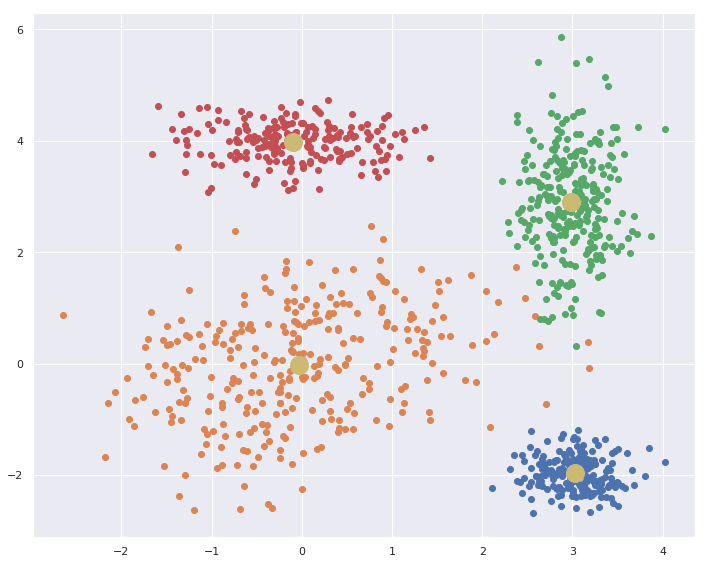

In [58]:
visualize_data(X, Y)

## K-Means Clustering

k-Means clustering is one of the simplest and most commonly used clustering algorithms. It tries to find cluster centers that are representative of certain regions of the data. The algorithm alternates between two steps: assigning each data point to the closest cluster center, and then setting each cluster center as the mean of the data points that are assigned to it. The algorithm is finished when the assignment of instances to clusters no longer changes.

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here. In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
3. E-Step: assign points to the nearest cluster center
4. M-Step: set the cluster centers to the mean

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to. The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

In [59]:
def find_clusters_kmeans(X, k):
    eps = 10**5
    idx = np.random.choice(range(len(X)), size=k, replace=False)
    old_centroids = {i:m for i,m in enumerate(X[idx])}
    clusters = get_clusters(X, old_centroids)
    return clusters

We specified that we are looking for four clusters, so the algorithm was initialized by declaring four data points as cluster centers. Then the iterative algorithm starts: Each data point is assigned to the cluster center it is closest to. Next, the cluster centers are updated to be the mean of the assigned points. Then the process is repeated.

Iterations: 4


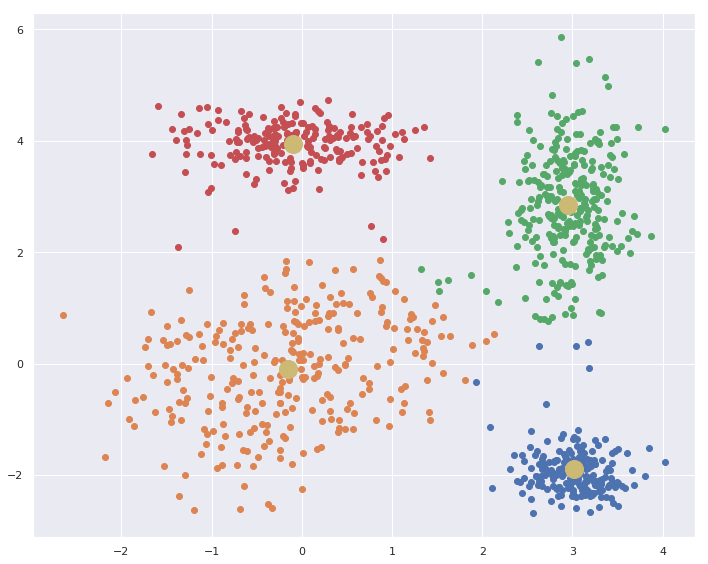

In [60]:
clusters = find_clusters_kmeans(X, 4)

## Meanshift Clustering

Meanshift is a clustering algorithm that assigns the datapoints to the clusters iteratively by shifting points towards the high density regions. As such, it is also known as the mode-seeking algorithm. Meanshift algorithm has applications in the field of image processing and computer vision.

Given a set of datapoints, the algorithm iteratively assign each datapoint towards the closest cluster centroid. The direction to the closest cluster centroid is determined by where most of the points nearby are at. So each iteration each data point will move closer to where the most points are at, which is or will lead to the cluster center. When the algorithm stops, each point is assigned to a cluster.

Unlike the popular K-Means algorithm, meanshift does not require specifying the number of clusters in advance. The number of clusters is determined by the algorithm with respect to the data.

We first define a couple of helper functions. We will need a few things before we start to run Meanshift on a set of datapoints X:

1. A function $N(x)$ to determine what are the neighbours of a point $x \in X$. The neighbouring points are the points within a certain radius. The distance metric is usually Euclidean Distance.
2. A kernel $K(d)$ to use in Meanshift. $K$ is usually a Gaussian or a Linear Kernel, and $d$ is the distance between two datapoints.

In [61]:
def neighbourhood_points(X, x_centroid, radius = 5):
    eligible_X = []
    for x in X:
        distance_between = euclidian_distance(x, x_centroid)
        if distance_between <= radius:
            eligible_X.append(x)
    return eligible_X

def gaussian_kernel(distance, kernel_bandwidth):
    val = (1/(kernel_bandwidth*math.sqrt(2*math.pi))) * np.exp(-0.5*((distance / kernel_bandwidth))**2)
    return val

Here is how the algorithm works:

1. For each datapoint $x \in X$, find the neighbouring points $N(x)$ of $x$.
2. For each datapoint $x \in X$, calculate the mean shift $m(x)$ from this equation: 

$$m(x) = \frac{\sum_{x_i \in N(x_i)} K(x_i-x)x_i }{\sum_{x_i \in N(x_i)} K(x_i-x)} $$

3. For each datapoint $x \in X$, update $x \leftarrow m(x)$.
4. Repeat 1 for $N_{iteations}$ or until the points are stationary or almost stationary.

For a Gaussian Kernel
$$K(x_i -x) = \frac{1}{\sqrt{2\pi w^2}}e^{-\frac{1}{2}\frac{(x_i-x)^T(x_i-x)}{w^2}}$$

For a Linear Kernel
$$K(x_i -x) = c $$


In [62]:
def visualize_mean_shift(data, centroids):
    plt.plot(data[:,0], data[:,1], 'bo')
    plt.plot(np.array(list(centroids.values()))[:,0], 
             np.array(list(centroids.values()))[:,1], 'ro')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
def optimize_centroid(centroid, neighbours, kernel_bandwidth=2, kernel='linear'):
    numerator = 0
    denominator = 0
    for neighbour in neighbours:
        distance = euclidian_distance(neighbour, centroid)
        if kernel == 'linear':
            weight = 1
        elif kernel == 'gaussian':
            weight = gaussian_kernel(distance=distance, kernel_bandwidth=kernel_bandwidth)
        numerator += (weight * neighbour)
        denominator += weight
    new_centroid = np.round(numerator / denominator, 6)
    return new_centroid

def optimize_all_centroids(data, centroids, kernel_bandwidth=2, kernel='linear'):
    new_centroids = []
    for i in centroids:
        centroid = centroids[i]
        neighbours = neighbourhood_points(data, centroid, radius=kernel_bandwidth)
        new_centroid = optimize_centroid(centroid, neighbours, kernel=kernel,
                                         kernel_bandwidth=kernel_bandwidth)
        new_centroids.append(tuple(new_centroid))

    uniques = np.array(sorted(list(set(new_centroids))))
    centroids = {i:m for i,m in enumerate(uniques)}
    return centroids

def centroids_convergance(data, centroids, kernel_bandwidth=2, 
                          kernel='linear', thresh=10**-3, iterations=0):
    while True:
        iterations += 1
        lst = (iterations, len(centroids), kernel_bandwidth)
        plt.clf()
        plt.title(f'Iteration: {iterations} \
            Centroids: {len(centroids)} \
            Kernel Bandwidth: {kernel_bandwidth}')
        visualize_mean_shift(data, centroids)
        old_centroids = dict(centroids)
        centroids = optimize_all_centroids(data, centroids, kernel=kernel,
                                           kernel_bandwidth=kernel_bandwidth)

        optimized = False
        if len(centroids) == len(old_centroids):
            eps = np.mean([euclidian_distance(centroids[i], old_centroids[i]) 
                           for i in centroids])
            if eps < thresh:
                optimized = True
                
        if optimized:
            break      
    return centroids, iterations

def find_clusters_meanshift(data, centroids=None, kernel_bandwidth=2, kernel='linear', 
                            sample_fraction=1, thresh=10**-3, iterations=0):
    start = time.time()
    sleep_time = 1
    if centroids == None:
        centroids = {}
        if sample_fraction == 1:
            centroids = data.copy()
        else:
            idx = np.random.choice(range(len(data)), 
                                   size=round(sample_fraction*len(data)), 
                                   replace=False)
            centroids = data[idx]
    centroids = {i:m for i,m in enumerate(centroids)}
    secondary_thresh = 0.5
    
    radius_check = kernel_bandwidth > secondary_thresh
    fig = plt.figure(figsize = (10,8))
    centroids, iterations = centroids_convergance(data, centroids, kernel_bandwidth=kernel_bandwidth, 
                                                  kernel=kernel, thresh=thresh, iterations=iterations)
    if not radius_check:
        return centroids
    t1 = time.time()-start
    n_centroids = len(centroids)
    if radius_check: # Modification made for faster convergance
        plt.close()
        centroids = find_clusters_meanshift(data, centroids=list(centroids.values()), 
                                            kernel_bandwidth=secondary_thresh, iterations=iterations)
        print(round(t1, 2), round(time.time()-start, 2))
    return centroids

21.93 26.34


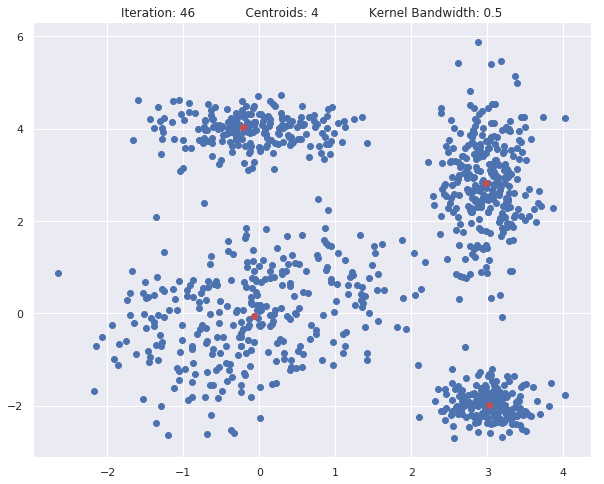

In [63]:
centroids = find_clusters_meanshift(X, kernel_bandwidth=1.5, kernel='gaussian', 
                                    sample_fraction=0.1, thresh=10**-3)

Refactoring using the same clustering routine as done for K-means Algorithm

Iterations: 3


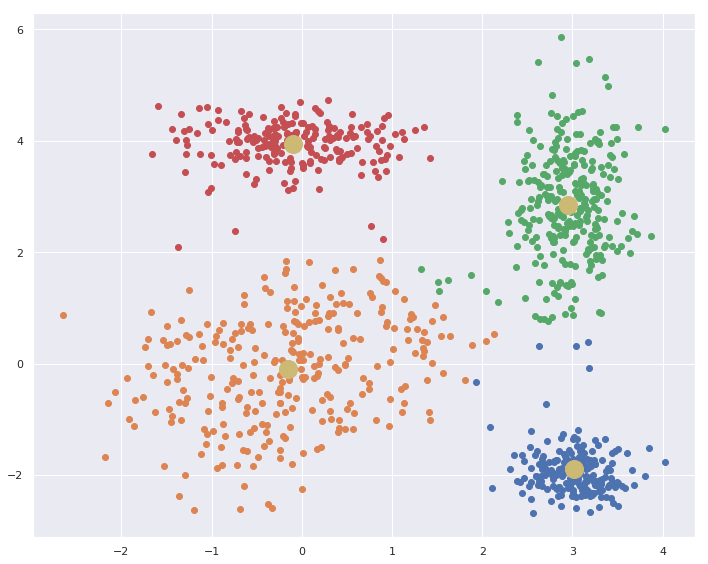

In [65]:
clusters = get_clusters(X, centroids)